In [ ]:
!pip install tensorflow

In [44]:
!pip install table_evaluator

In [ ]:

import tensorflow as tf

from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout, Input
from keras.layers import Dense, Flatten, GlobalMaxPooling1D 
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.models import Sequential, Model
# from keras.optimizers import Adam, SGD
# from tf.keras.optimizers import Adam, SGD
from scipy import stats
from scipy.signal import butter, lfilter, freqz

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np


import matplotlib.pyplot as plt

import random
import sys
import os

ImportError: ignored

In [ ]:
pip install numpy==1.19.5

     |████████████████████████████████| 14.8 MB 5.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
df_train = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data_train.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data_test.xlsx')

## Anomigan

In [ ]:

tf.compat.v1.disable_eager_execution()

GPUID = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)

class ANOMIGAN():
    def __init__(self):
        self.testfile = df_test
        self.data = df_train
        self.num_feature = 30
        self.X_test = 0 
        self.X_gen = 0 
        self.scaler = MaxAbsScaler() 
        self.input_shape = (-1,-1) 
        self.latent_dim = 100
        self.C= tf.compat.v1.placeholder(tf.float32, shape = [None, 512])
        self.C_prime = tf.compat.v1.placeholder(tf.float32, shape = [None, 512])

        # models
        self.generator = None
        self.discriminator = None
        self.preTrainedModel = Sequential()

        # hyperparameter for loss
        self.lambda_a = 0.5
        self.lambda_b = 1 - self.lambda_a
        self.confidence = 1.0
        self.batch_size = 32
        self.num_variance = 5

        # temp Lists
        self.bList = []
        self.aList = []

        self.bFpr = []
        self.bTpr = []
        self.bThresholds = []

        self.aFpr = []
        self.aTpr = []
        self.aThresholds = []

        self.t_var = {}

######## drawring functions ###############
    def butter_lowpass_filter(self, data, cutoff, fs, order=5):
        b, a = self.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    def butter_lowpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def drawLoss(self, S_loss_list, E_loss_list):
        # Filter requirements.
        order = 6
        fs = 30.0       # sample rate, Hz
        cutoff = 3.667  # desired cutoff frequency of the filter, Hz

        s_filter = self.butter_lowpass_filter(S_loss_list, cutoff, fs, order)
        d_filter = self.butter_lowpass_filter(E_loss_list, cutoff, fs, order)

        ylim = [0,3]
        f = plt.figure(tight_layout=True)  
        ax = f.add_subplot(111, ylim=ylim)
        ax.set_xlabel("Epochs",fontsize=20)
        ax.set_ylabel("Loss",fontsize=20)
        ax.plot(s_filter, label='Discriminator', color='blue', linewidth=1, linestyle='--' )
        ax.plot(d_filter, label='Encoder', color='green', linewidth=1, alpha=0.5 )
        ax.legend(loc=1,fontsize=15)

        plt.show()

    def drawAccuracyPlot(self):
        ylim = [0,105]
        xlim = [0, 10]
        f = plt.figure(tight_layout=True)  
        ax = f.add_subplot(111, ylim=ylim)
        ax.set_xlabel("Random Iterative Steps",fontsize=20)
        ax.set_ylabel("Accuracy",fontsize=20)
        plt.plot(self.bList, label='Original Samples', color='blue', linewidth=1, linestyle='--' )
        plt.plot(self.aList, label='Generated Samples', color='green', linewidth=1, )
        plt.legend()

        plt.show()

    def drawRocPlot(self):
        fpr1, tpr1, thresholds1 = self.bFpr, self.bTpr, self.bThresholds   
        roc_auc1 = auc(fpr1, tpr1)
 
        fpr2, tpr2, thresholds2 = self.aFpr, self.aTpr, self.aThresholds
        roc_auc2 = auc(fpr2, tpr2)

        plt.figure()
        plt.plot(fpr1, tpr1, color='blue', linestyle='--', linewidth=2, label='ROC curve with original samples (area = %0.2f)' % roc_auc1)
        plt.plot(fpr2, tpr2, color='green', linewidth=1, label='ROC curve with generated samples (area = %0.2f)' % roc_auc2)
        plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle=':')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

######## target classifer model functions ###############
    def get_pretrainModel(self):
        return self.preTrainedModel

    def get_target_features(self):
        X = 1
        Y = 1
        return X, Y 

######## AnomiGAN model functions ###############
    def discriminator(self, x):
        with tf.variable_scope("discriminator"):
            x_reshaped = tf.reshape(x, (-1, self.num_feature, 1))
            conv1 = tf.layers.conv1d(x_reshaped, filters=32, kernel_size=4, 
                                                        strides=2,
                                                        padding='VALID',
                                                        activation=tf.nn.relu)
            conv2 = tf.layers.conv1d(conv1, filters=10,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
            conv3 = tf.layers.conv1d(conv1, filters=20,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
            conv4 = tf.layers.conv1d(conv1, filters=30,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
            flatten = tf.layers.flatten(conv4)
            out = tf.layers.dense(flatten, self.num_feature, activation=tf.nn.relu)
            return out

    def operation_mode(self, x, message, mode):
        if mode == 1:
            dtype = x.dtype
            x_btensor = tf.cast(x, tf.int32)
            m_btensor = tf.cast(message, tf.int32)
            xor = tf.bitwise.bitwise_xor(x_btensor, m_btensor)
            random = tf.cast(xor, tf.float32)  #dbo  
        else:
            random = x*message % tf.argmax(x) 

    def encoder(self, x, message, mode):
        with tf.compat.v1.variable_scope("encoder"):
            random = self.operation_mode(x, message, mode)
            x_flatten = tf.layers.flatten(random)
            fc1 = tf.reshape(x_flatten, (-1, self.num_feature, 1)) 
            conv1d_t1 = tf.layers.conv1d(fc1, filters=64, kernel_size=4, 
                                                        strides=2,
                                                        padding='VALID',
                                                        activation=tf.nn.relu)
            bn1 = tf.layers.batch_normalization(conv1d_t1)
            conv1d_t2 = tf.layers.conv1d(bn1, filters=32,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)

            bn2 = tf.layers.batch_normalization(conv1d_t2)
            conv1d_t3 = tf.layers.conv1d(bn2, filters=16,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)

            bn3 = tf.layers.batch_normalization(conv1d_t3)
            conv1d_t4 = tf.layers.conv1d(bn3, filters=8,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)

            bn4 = tf.layers.batch_normalization(conv1d_t4)
            conv1d_t5 = tf.layers.conv1d(bn4, filters=4,
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
    
            bn5 = tf.layers.batch_normalization(conv1d_t5)
            conv1d_t6 = tf.layers.conv1d(bn5, filters=8, 
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
 
            bn6 = tf.layers.batch_normalization(conv1d_t6)
            conv1d_t7 = tf.layers.conv1d(bn6, filters=16, 
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)

            bn7 = tf.layers.batch_normalization(conv1d_t7)
            conv1d_t8 = tf.layers.conv1d(bn7, filters=self.num_feature, 
                                                       kernel_size=2,
                                                       strides=1,
                                                       padding='SAME',
                                                       activation=tf.nn.tanh)
            flatten = tf.layers.flatten(conv1d_t8)
            out = tf.layers.dense(flatten, self.num_feature, activation=tf.nn.relu)
            return out

    def get_solvers(self, learning_rate=1e-3, beta1=0.5):
        E_solver = tf.train.AdamOptimizer(learning_rate, beta1)
        S_solver = tf.train.AdamOptimizer(learning_rate, beta1)
        return E_solver, S_solver

    def train(self, sess, E_train_step, S_train_step, E_loss, S_loss, epochs=3000, batch_size=10):
        X, Y = self.get_target_features() 
        for it in range(epochs):
            minibatch, labels = self.get_shuffle_batch(X, Y, batch_size)
            minibatch = minibatch.reshape(batch_size, -1)

            if epochs > (epochs - 2000): 
                self.store_parameters(sess)

            #randomize original data
            fake = np.random.normal(0, 1, (batch_size, 30))
            randomized = sess.run(self.C_prime, feed_dict = {self.C:minibatch, self.random:fake})
            loss = self.target_classifier(randomized, labels, batch_size) 

            _, S_loss_curr = sess.run([S_train_step, S_loss], feed_dict={self.C:minibatch, self.random:fake,
            self.loss:loss})

            _, E_loss_curr = sess.run([E_train_step, E_loss], feed_dict={self.C:minibatch, self.random:fake,
            self.loss:loss})

            S_loss_list.append(S_loss_curr)
            E_loss_list.append(np.mean(E_loss_curr))

        #self.drawLoss(S_loss_list, E_loss_list) 
        print ("Train Finishied")

    def target_classifier(self, fake, fake_label, batch_size=32):
        cvscores = []
        scores = self.preTrainedModel.evaluate(fake, fake_label, verbose=0)
        output = np.mean(scores[1])
        return output 

    def calculate_loss(self, C, C_prime, logit_real, logit_fake, loss):
        real_label = tf.ones_like(logit_real)
        fake_label = tf.zeros_like(logit_fake)

        loss_S_real = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=real_label, logits=logit_real)
        loss_S_fake = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=fake_label, logits=logit_fake)

        loss_S = (tf.reduce_mean(loss_S_real) + (tf.reduce_mean(loss_S_fake)* (1-tf.reduce_mean(loss))))
        C_flatten = tf.layers.flatten(C)
        C_prime_flatten = tf.layers.flatten(C_prime)
        distance = (tf.sqrt(tf.reduce_sum(tf.square(C_flatten - C_prime_flatten), axis=1))) 
        distance = tf.reduce_mean(distance)
        loss_E = (self.lambda_a * (distance*self.confidence) )  + (self.lambda_b * loss_S)
        return loss_E, loss_S 

    def get_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        return session

    def get_shuffle_batch(self, X, Y, batch_size=32):
        idx = random.randint(1, len(X)-batch_size)
        return  X[idx:idx+batch_size], Y[idx:idx+batch_size]

    def get_next_batch(self, X, Y, start, end, batch_size=32):
        X_train = []
        Y_train = []
        start = 0
        end = batch_size
        for i in range(len(X)-batch_size):
            start+=i
            end+=i
            X_train.append(X[start:end])
            Y_train.append(Y[start:end])
        return X_train, Y_train 

    def anonymize_sample(self, sess, batch_size):
        cvscores1 = []
        minibatch, labels = self.get_target_features() 
        batch_size = len(Y)
        fake = np.random.normal(0, 1, (batch_size, 30))
        randomized = sess.run(self.C_prime, feed_dict = {self.C:minibatch, self.random:fake})
        scores1 = self.preTrainedModel.evaluate(randomized, Y, verbose=0)
        cvscores1.append(scores1[1] * 100)
        self.get_inversed(randomized) 

    def get_inversed(self, normalized):
        np.set_printoptions(precision=6, suppress=True)
        inversed = self.scaler.inverse_transform(normalized)
        np.savetxt('fileout.txt', inversed, delimiter=',', fmt='%1.3f') 
        return inversed

    def store_parameters(self, sess):
        for i in range(1, 7):
            name = 'Encoder/conv1d_' + i + '/kernel:0'
            conv = sess.graph.get_tensor_by_name(name)
            self.t_var[name] = conv
            self.t_var.append(name, sess.run(conv))

    def add_variance(self, sess, num_var):
        for i in range(num_var):
            num = random.randint(1, 7)
            name = 'Encoder/conv1d_' + num + '/kernel:0'
            conv = sess.graph.get_tensor_by_name(name)
            var = np.var(self.t_var.get(name), axis=0)
            sess.run(tf.assign(conv, conv + var))

    def get_pvalue(self, a, b):
        a = a.flatten()
        b = b.flatten() 
        t, p = stats.pearsonr(a,b)

    def main(self):
        self.get_pretrainModel()

        tf.compat.v1.reset_default_graph()

        self.C = tf.compat.v1.placeholder(tf.float32, shape = [None, self.num_feature])
        self.random = tf.compat.v1.placeholder(tf.float32, shape = [None, self.num_feature])

        self.C_prime = self.encoder(self.C, self.random, mode=2)
        self.loss = tf.compat.v1.placeholder(tf.float32)

        with tf.variable_scope("") as scope:
            logit_real = self.discriminator(self.C)
            scope.reuse_variables()
            logit_fake = self.discriminator(self.C_prime)


        encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
        steganalayzer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

        E_solver, S_solver = self.get_solvers()

        E_loss, S_loss = self.calculate_loss(self.C, self.C_prime, logit_real, logit_fake, self.loss)
        E_train_step = E_solver.minimize(E_loss, var_list=encoder_vars)
        S_train_step = E_solver.minimize(S_loss, var_list=steganalayzer_vars)

        tf.executing_eagerly()
        sess = self.get_session() 
        sess.run(tf.global_variables_initializer())
        self.train(sess, E_train_step, S_train_step, E_loss, S_loss)

        self.add_variance(sess, self.num_variance) 
        self.anonymize_sample(sess, self.batch_size)       


if __name__ == '__main__':
    anomigan = ANOMIGAN()
    anomigan.main()

TypeError: ignored

## CTGAN

In [ ]:
pip install ctgan

     |████████████████████████████████| 15.7 MB 6.9 MB/s 
     |████████████████████████████████| 280 kB 37.2 MB/s 
     |████████████████████████████████| 22.3 MB 64.9 MB/s 
     |████████████████████████████████| 636 kB 52.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Unin

In [111]:
from ctgan import CTGANSynthesizer
from ctgan import load_demo
import pandas as pd

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        278 non-null    datetime64[ns]
 1   ATM ID                       278 non-null    int64         
 2   Location Description         278 non-null    object        
 3   Street Number                278 non-null    object        
 4   Postal Code                  278 non-null    int64         
 5   City                         278 non-null    object        
 6   Withdrawal                   278 non-null    int64         
 7   Withdrawal CHF               278 non-null    int64         
 8   Transactions Inquiry         278 non-null    int64         
 9   Balance Inquiry              278 non-null    int64         
 10  Withdrawal Own Bank          278 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

In [ ]:
df = df.dropna()
df

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1887,912230,336,29,1714,841530.0,173,70700.0
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,865,456450,163,28,758,416070.0,107,40380.0
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1120,726170,423,21,981,634500.0,139,91670.0
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1770,1173100,308,39,1513,1065890.0,257,107210.0
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,2098,801640,137,81,1536,660650.0,562,140990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-05-31,2793,CC Wollishofen.,Alte Kalchbuehlstrasse 15,8038,Zuerich,1072,329220,40,251,113,64660.0,959,264560.0
274,2020-05-31,2802,Zuerich Lochergut,Zentrum Lochergut,8004,Zuerich,4786,938800,102,1632,324,160240.0,4462,778560.0
275,2020-05-31,2818,CC Wiedikon,Birmensdorfstrasse 20,8004,Zuerich,597,266620,111,100,274,186790.0,323,79830.0
276,2020-05-31,2847,CC Zuerich Nord,Binzmuehlestrasse,8050,Zuerich,1094,2847080,28,299,99,433180.0,995,2413900.0


In [ ]:
df['Month']=df['Month'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        273 non-null    object 
 1   ATM ID                       273 non-null    int64  
 2   Location Description         273 non-null    object 
 3   Street Number                273 non-null    object 
 4   Postal Code                  273 non-null    int64  
 5   City                         273 non-null    object 
 6   Withdrawal                   273 non-null    int64  
 7   Withdrawal CHF               273 non-null    int64  
 8   Transactions Inquiry         273 non-null    int64  
 9   Balance Inquiry              273 non-null    int64  
 10  Withdrawal Own Bank          273 non-null    int64  
 11  Withdrawal CHF Own Bank      273 non-null    float64
 12  Withdrawal Foreign Bank      273 non-null    int64  
 13  Withdrawal CHF Forei

### Modelling

In [ ]:
discrete_columns = ['Month',
                    'ATM ID', 
                    'Location Description', 
                    'Street Number',
                    'Postal Code', 
                    'City', 
                    'Withdrawal', 
                    'Withdrawal CHF',
                    'Transactions Inquiry', 
                    'Balance Inquiry', 
                    'Withdrawal Own Bank',
                    'Withdrawal CHF Own Bank', 
                    'Withdrawal Foreign Bank',
                    'Withdrawal CHF Foreign Bank']

ctgan = CTGANSynthesizer(epochs=10)
ctgan.fit(df, discrete_columns)

# Synthetic copy
samples = ctgan.sample(1000)

In [ ]:
samples

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,1253,CS ZH Oerlikon 7,Badenerstrasse 694,8048,Zuerich Wiedikon,3198,530240,407,4,370,29240.0,320,391850.0
1,2020-05-31,1650,UBS ZH VZA1,Seidengasse 17,8152,Zuerich Seefeld,181,566520,219,717,2132,92130.0,204,185090.0
2,2020-05-31,1368,ZKB ZH Klusplatz 1,Langstr. 21,8910,Zuerich,1559,19059640,611,221,32,3870.0,313,258620.0
3,2020-05-31,232,ZKB ZH Technopark,Birmensdorfstrasse 20,8023,Zürich Enge,703,1446390,279,17,579,619440.0,1028,522950.0
4,2020-05-31,2441,ZKB ZH Schwamend.,Europaallee 23,8055,Zuerich,922,1189690,788,14,897,809840.0,55,198990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2020-05-31,1304,ZKB ZH Friesenberg,Witikonerstr. 377,8047,Zürich Seefeld,75,733260,256,160,571,21720.0,842,42290.0
996,2020-05-31,2090,ZKB ZH Uni Raemist,Birmensdorferstrasse 80,8037,Zuerich Seefeld,2257,275390,382,43,242,110930.0,946,357980.0
997,2020-05-31,2518,ZKB ZH Affoltern 1,Schaffhauserstr. 11,8049,Zuerich,1770,1145900,239,57,1534,467690.0,184,19200.0
998,2020-05-31,1500,ZKB ZH Wiedikon 1,Forchstr. 9,8047,Zuerich Seefeld,945,1248910,90,200,409,151350.0,2118,375330.0


### Evaluation

In [ ]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(df, sample, cat_cols=df_cat.columns.values.tolist())

## TGAN 
https://github.com/sdv-dev/TGAN

In [ ]:
!pip install tgan

     |████████████████████████████████| 273 kB 6.3 MB/s 
     |████████████████████████████████| 110.5 MB 1.9 kB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 3.8 MB 31.1 MB/s 
     |████████████████████████████████| 503 kB 50.8 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 34.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7d0510e576a2c192677919acb305a7d7d557b62de6478dd94b789cecfe4d964c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: t

In [ ]:
from tgan.data import load_demo_data
data, continuous_columns = load_demo_data('census')
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,6418,0,9,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,157,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,Poland,Poland,Germany,Foreign born- U

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data.xlsx')
df.info()
df = df.dropna()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        278 non-null    datetime64[ns]
 1   ATM ID                       278 non-null    int64         
 2   Location Description         278 non-null    object        
 3   Street Number                278 non-null    object        
 4   Postal Code                  278 non-null    int64         
 5   City                         278 non-null    object        
 6   Withdrawal                   278 non-null    int64         
 7   Withdrawal CHF               278 non-null    int64         
 8   Transactions Inquiry         278 non-null    int64         
 9   Balance Inquiry              278 non-null    int64         
 10  Withdrawal Own Bank          278 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1887,912230,336,29,1714,841530.0,173,70700.0
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,865,456450,163,28,758,416070.0,107,40380.0
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1120,726170,423,21,981,634500.0,139,91670.0
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1770,1173100,308,39,1513,1065890.0,257,107210.0
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,2098,801640,137,81,1536,660650.0,562,140990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-05-31,2793,CC Wollishofen.,Alte Kalchbuehlstrasse 15,8038,Zuerich,1072,329220,40,251,113,64660.0,959,264560.0
274,2020-05-31,2802,Zuerich Lochergut,Zentrum Lochergut,8004,Zuerich,4786,938800,102,1632,324,160240.0,4462,778560.0
275,2020-05-31,2818,CC Wiedikon,Birmensdorfstrasse 20,8004,Zuerich,597,266620,111,100,274,186790.0,323,79830.0
276,2020-05-31,2847,CC Zuerich Nord,Binzmuehlestrasse,8050,Zuerich,1094,2847080,28,299,99,433180.0,995,2413900.0


In [ ]:
continuous_columns = [6, 7, 8, 9, 10, 11, 12, 13]
continuous_columns

[6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
from tgan.model import TGANModel
tgan = TGANModel(continuous_columns,max_epoch=5)

In [ ]:
tgan.fit(df)




[0127 10:57:47 @input_source.py:222] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...








Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[0127 10:57:48 @registry.py:126] gen/LSTM/00/FC input: [200, 100]

Instructions for updating:
Please use `layer.__call__` method instead.
[0127 10:57:48 @registry.py:134] gen/LSTM/00/FC output: [200, 100]
[0127 10:57:48 @registry.py:126] gen/LSTM/00/FC2 input: [200, 100]
[0127 10:57:48 @registry.py:134] gen/LSTM/00/FC2 output: [200, 1]
[0127 10:57:48 @registry.py:126] gen/LSTM/00/FC3 input: [200, 1]
[0127 10:57:48 @registry.py:134] gen/LSTM/00/FC3 output: [200, 100]
[0127 10:57:48 @registry.py:126] gen/LSTM/01/FC input: [200, 100]
[0127 10:57:48 @registry.

100%|#########9|9999/10000[44:28<00:00, 3.82it/s]

100%|##########|10000/10000[44:31<00:00, 3.74it/s]

[0127 11:42:49 @base.py:285] Epoch 1 (global_step 10000) finished, time:44 minutes 31 seconds.



[0127 11:42:49 @saver.py:79] Model saved to output/model/model-10000.
[0127 11:42:49 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.875
[0127 11:42:49 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.65
[0127 11:42:49 @monitor.py:467] GAN_loss/discrim/loss: 0.52163
[0127 11:42:49 @monitor.py:467] GAN_loss/gen/final-g-loss: 1.7774
[0127 11:42:49 @monitor.py:467] GAN_loss/gen/klloss: 0.15233
[0127 11:42:49 @monitor.py:467] GAN_loss/gen/loss: 1.625
[0127 11:42:49 @monitor.py:467] QueueInput/queue_size: 50
[0127 11:42:49 @base.py:275] Start Epoch 2 ...


100%|##########|10000/10000[43:42<00:00, 3.81it/s]

[0127 12:26:31 @base.py:285] Epoch 2 (global_step 20000) finished, time:43 minutes 42 seconds.
[0127 12:26:31 @saver.py:79] Model saved to output/model/model-20000.
[0127 12:26:31 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.86
[0127 12:26:31 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.66
[0127 12:26:31 @monitor.py:467] GAN_loss/discrim/loss: 0.53758
[0127 12:26:31 @monitor.py:467] GAN_loss/gen/final-g-loss: 2.064
[0127 12:26:31 @monitor.py:467] GAN_loss/gen/klloss: 0.076086
[0127 12:26:31 @monitor.py:467] GAN_loss/gen/loss: 1.988
[0127 12:26:31 @monitor.py:467] QueueInput/queue_size: 50
[0127 12:26:31 @base.py:275] Start Epoch 3 ...



100%|##########|10000/10000[44:26<00:00, 3.75it/s]

[0127 13:10:57 @base.py:285] Epoch 3 (global_step 30000) finished, time:44 minutes 26 seconds.
[0127 13:10:57 @saver.py:79] Model saved to output/model/model-30000.
[0127 13:10:57 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.82
[0127 13:10:57 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.68
[0127 13:10:57 @monitor.py:467] GAN_loss/discrim/loss: 0.52159
[0127 13:10:57 @monitor.py:467] GAN_loss/gen/final-g-loss: 1.8799
[0127 13:10:57 @monitor.py:467] GAN_loss/gen/klloss: 0.062565
[0127 13:10:57 @monitor.py:467] GAN_loss/gen/loss: 1.8173
[0127 13:10:57 @monitor.py:467] QueueInput/queue_size: 50
[0127 13:10:57 @base.py:275] Start Epoch 4 ...



100%|##########|10000/10000[44:39<00:00, 3.73it/s]

[0127 13:55:37 @base.py:285] Epoch 4 (global_step 40000) finished, time:44 minutes 39 seconds.
[0127 13:55:37 @saver.py:79] Model saved to output/model/model-40000.
[0127 13:55:37 @monitor.py:467] GAN_loss/discrim/accuracy_fake: 0.885
[0127 13:55:37 @monitor.py:467] GAN_loss/discrim/accuracy_real: 0.725
[0127 13:55:37 @monitor.py:467] GAN_loss/discrim/loss: 0.45669
[0127 13:55:37 @monitor.py:467] GAN_loss/gen/final-g-loss: 2.3679
[0127 13:55:37 @monitor.py:467] GAN_loss/gen/klloss: 0.11635
[0127 13:55:37 @monitor.py:467] GAN_loss/gen/loss: 2.2516
[0127 13:55:37 @monitor.py:467] QueueInput/queue_size: 50
[0127 13:55:37 @base.py:275] Start Epoch 5 ...



 79%|#######8  |7860/10000[35:03<09:37, 3.71it/s]

In [ ]:
num_samples = 1000
samples = tgan.sample(num_samples)
samples.head(3).T[:10]

AttributeError: ignored

##TVAE: Triplet-Based Variational Autoencoder 
https://sdv.dev/SDV/user_guides/single_table/tvae.html

In [ ]:
!pip install sdv

     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 13.3 MB/s 
     |████████████████████████████████| 15.7 MB 38.7 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
     |████████████████████████████████| 22.3 MB 3.1 MB/s 
     |████████████████████████████████| 280 kB 36.0 MB/s 
     |████████████████████████████████| 636 kB 36.5 MB/s 
     |████████████████████████████████| 2.5 MB 13.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: 

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data.xlsx')
df.info()
df = df.dropna()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        278 non-null    datetime64[ns]
 1   ATM ID                       278 non-null    int64         
 2   Location Description         278 non-null    object        
 3   Street Number                278 non-null    object        
 4   Postal Code                  278 non-null    int64         
 5   City                         278 non-null    object        
 6   Withdrawal                   278 non-null    int64         
 7   Withdrawal CHF               278 non-null    int64         
 8   Transactions Inquiry         278 non-null    int64         
 9   Balance Inquiry              278 non-null    int64         
 10  Withdrawal Own Bank          278 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1887,912230,336,29,1714,841530.0,173,70700.0
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,865,456450,163,28,758,416070.0,107,40380.0
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1120,726170,423,21,981,634500.0,139,91670.0
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1770,1173100,308,39,1513,1065890.0,257,107210.0
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,2098,801640,137,81,1536,660650.0,562,140990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-05-31,2793,CC Wollishofen.,Alte Kalchbuehlstrasse 15,8038,Zuerich,1072,329220,40,251,113,64660.0,959,264560.0
274,2020-05-31,2802,Zuerich Lochergut,Zentrum Lochergut,8004,Zuerich,4786,938800,102,1632,324,160240.0,4462,778560.0
275,2020-05-31,2818,CC Wiedikon,Birmensdorfstrasse 20,8004,Zuerich,597,266620,111,100,274,186790.0,323,79830.0
276,2020-05-31,2847,CC Zuerich Nord,Binzmuehlestrasse,8050,Zuerich,1094,2847080,28,299,99,433180.0,995,2413900.0


In [ ]:
from sdv.tabular import TVAE

model = TVAE()

model.fit(df)

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [ ]:
new_data = model.sample(1000)
new_data.head()

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,507,ZKB ZH Prime Tower,Limmatquai 68,8004,Zuerich,624,-18020,161,93,161,90040.0,340,75830.0
1,2020-05-31,2331,MB ZH-SEIDENGASSE,Thurgauerstrasse 119,8000,Zuerich,346,224330,214,32,135,643270.0,376,132870.0
2,2020-05-31,2803,ZKB ZH Neumuenster,Ohmstrasse 2/4,8044,Zuerich,1410,431550,371,35,1644,529030.0,465,142420.0
3,2020-05-31,216,UBS ZH Bahnhofstr,Theaterstrasse 20,8004,Zuerich,375,237410,139,52,794,-12620.0,2,16270.0
4,2020-05-31,2509,UBS ZH Bahnhofstr,Bahnhofstr. 9,8001,Zuerich,510,417480,141,40,1203,708990.0,250,42690.0


In [ ]:
from table_evaluator import load_data, TableEvaluator

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        273 non-null    datetime64[ns]
 1   ATM ID                       273 non-null    int64         
 2   Location Description         273 non-null    object        
 3   Street Number                273 non-null    object        
 4   Postal Code                  273 non-null    int64         
 5   City                         273 non-null    object        
 6   Withdrawal                   273 non-null    int64         
 7   Withdrawal CHF               273 non-null    int64         
 8   Transactions Inquiry         273 non-null    int64         
 9   Balance Inquiry              273 non-null    int64         
 10  Withdrawal Own Bank          273 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

In [ ]:
cat_cols = ['Location Description', 'Street Number', 'City']

In [ ]:
table_evaluator = TableEvaluator(df, new_data, cat_cols=cat_cols)

/usr/local/lib/python3.7/dist-packages/table_evaluator/table_evaluator.py:88: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  self.real[self.numerical_columns].mean())
/usr/local/lib/python3.7/dist-packages/table_evaluator/table_evaluator.py:90: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  self.fake[self.numerical_columns].mean())


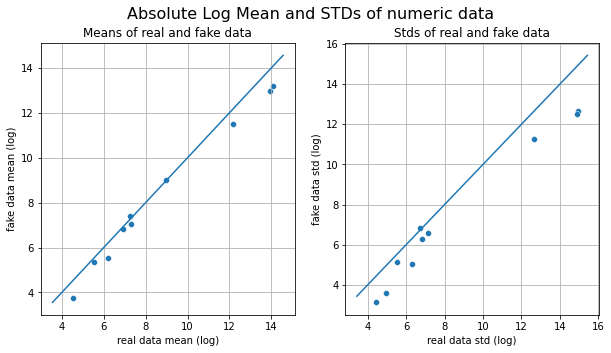

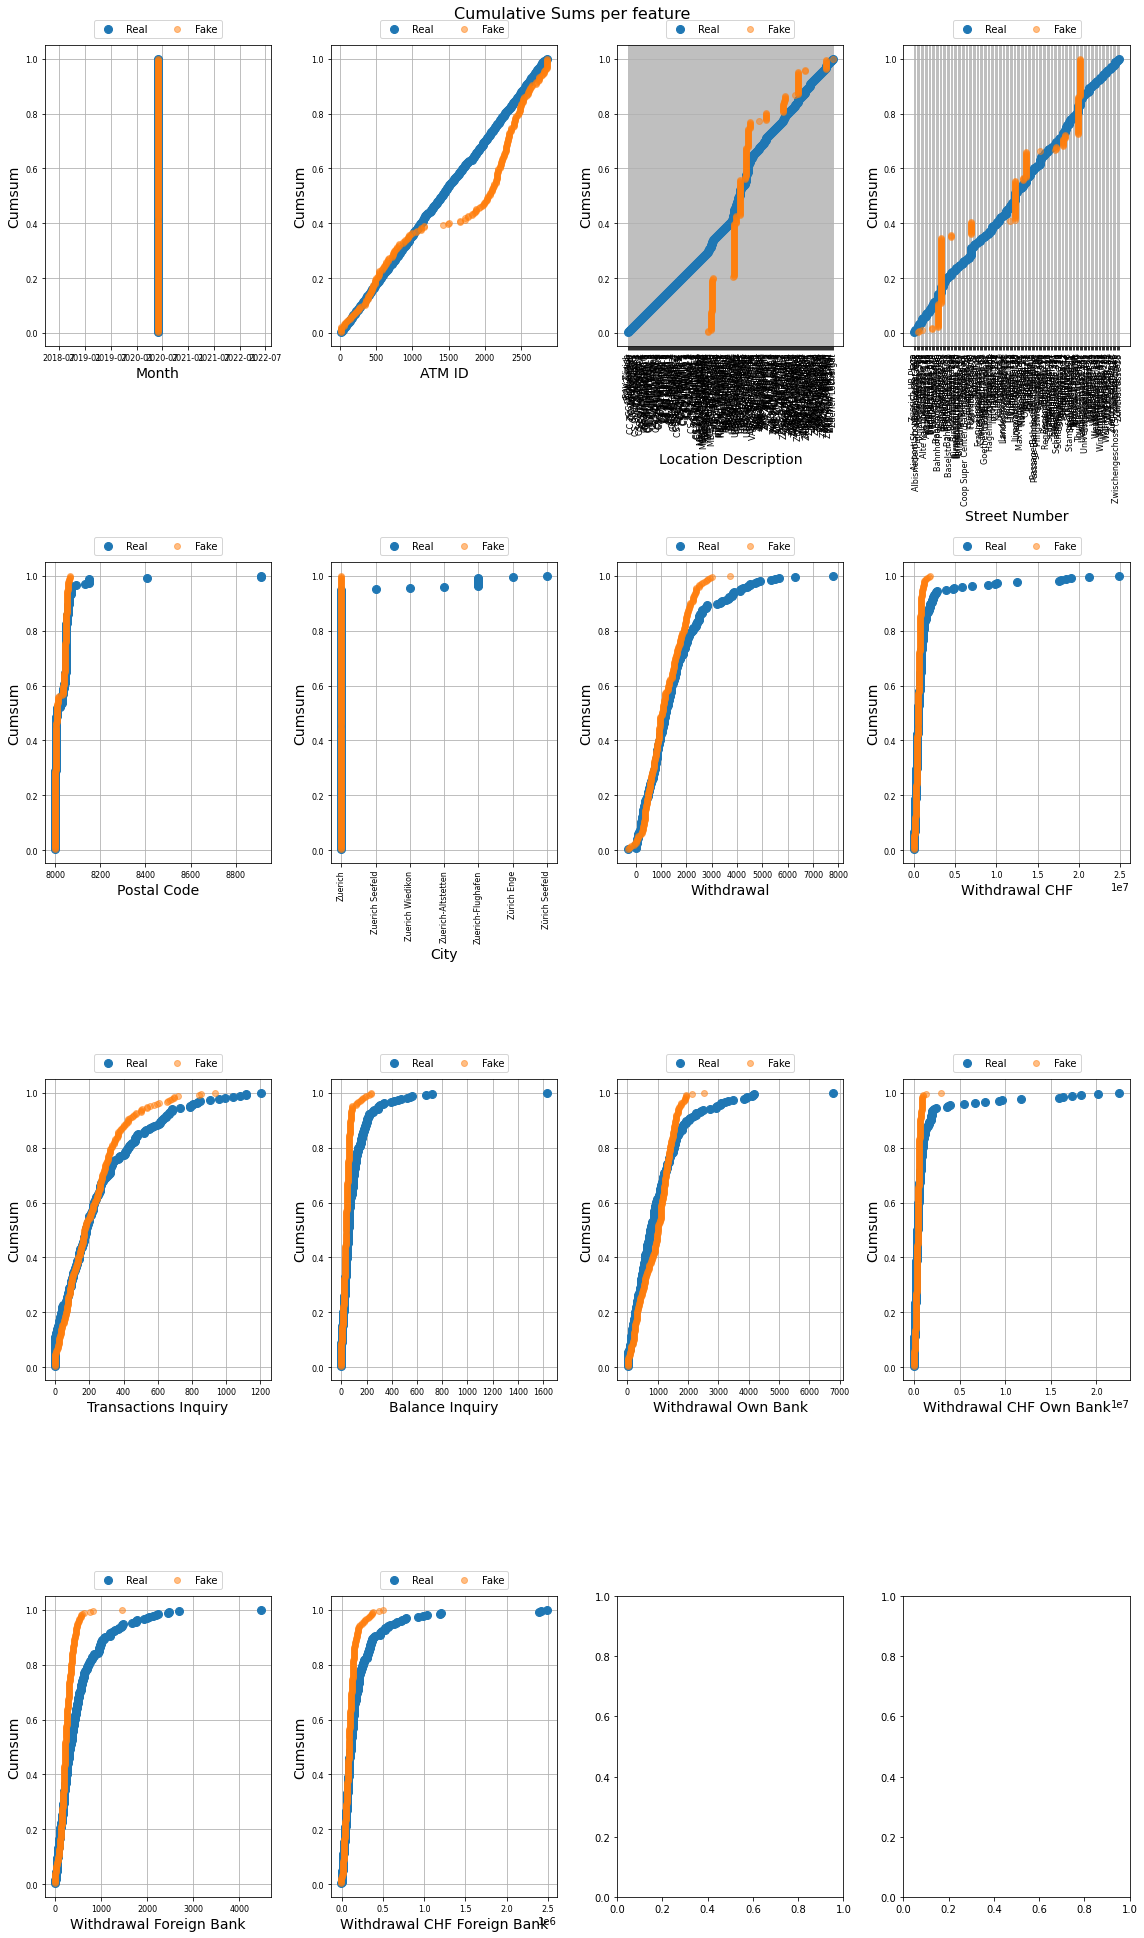

ValueError: ignored

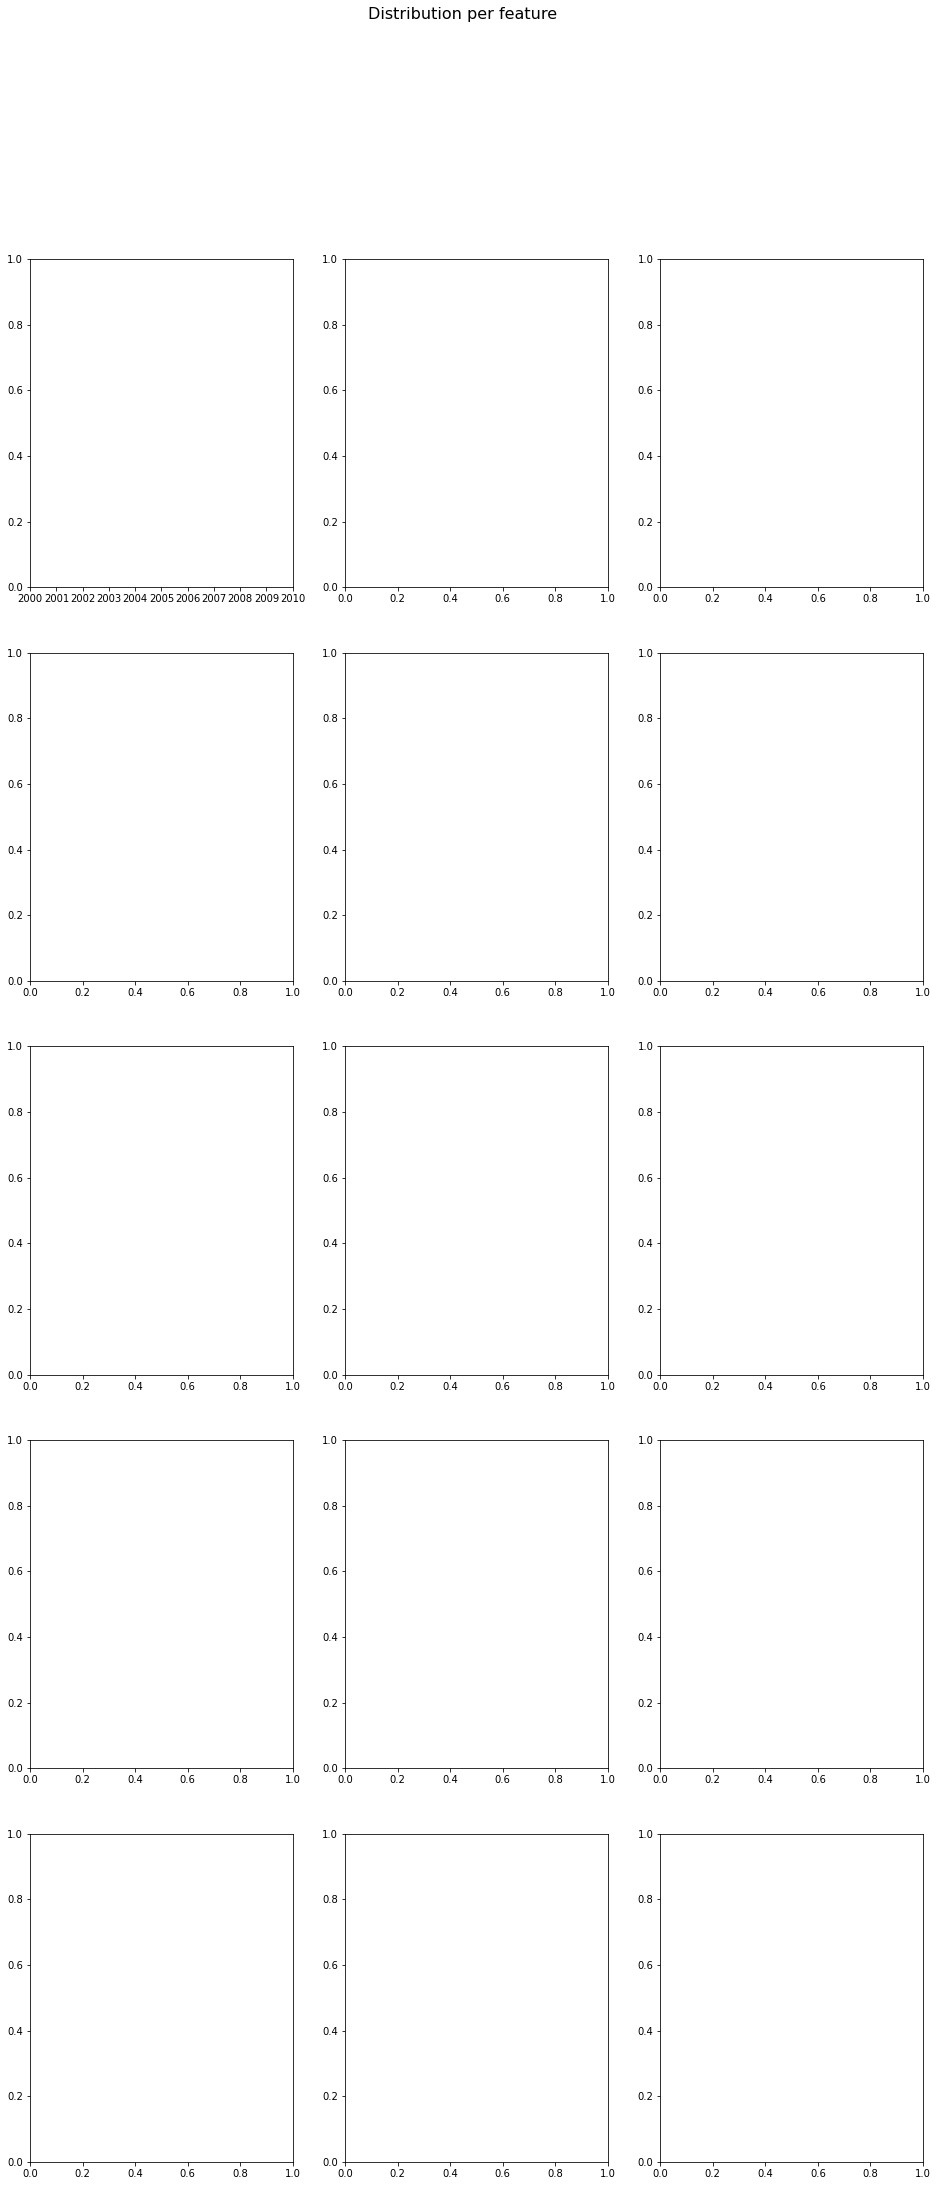

In [ ]:
table_evaluator.visual_evaluation()

## DoppelGANger
https://pub.towardsai.net/generating-synthetic-sequential-data-using-gans-a1d67a7752ac

In [ ]:
!pip install tensorflow-gan

In [ ]:
import sys
import os
sys.path.append("..")
import matplotlib.pyplot as plt

In [ ]:
from gan import output
sys.modules["output"] = output

ModuleNotFoundError: ignored

In [ ]:
from gan.doppelganger import DoppelGANger
from gan.load_data import load_data
from gan.network import DoppelGANgerGenerator, Discriminator, AttrDiscriminator

ModuleNotFoundError: ignored

## PATE-GAN
https://github.com/BorealisAI/private-data-generation

In [ ]:
!pip install python-utils 

In [ ]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_size, output_size, conditional=True):
        super().__init__()
        z = latent_size
        d = output_size
        if conditional:
            z = z + 1
        else:
            d = d + 1
        self.main = nn.Sequential(
            nn.Linear(z, 2 * latent_size),
            nn.ReLU(),
            nn.Linear(2 * latent_size, d))

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, input_size, wasserstein=False):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size + 1, int(input_size / 2)),
            nn.ReLU(),
            nn.Linear(int(input_size / 2), 1))

        if not wasserstein:
            self.main.add_module(str(3), nn.Sigmoid())

    def forward(self, x):
        return self.main(x)

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score


def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def pate(data, netTD, lap_scale):
    results = torch.Tensor(len(netTD), data.size()[0]).type(torch.int64)
    for i in range(len(netTD)):
        output = netTD[i].forward(data)
        pred = (output > 0.5).type(torch.Tensor).squeeze()
        results[i] = pred

    clean_votes = torch.sum(results, dim=0).unsqueeze(1).type(torch.cuda.DoubleTensor)
    noise = torch.from_numpy(np.random.laplace(loc=0, scale=1/lap_scale, size=clean_votes.size())).cuda()
    noisy_results = clean_votes + noise
    noisy_labels = (noisy_results > len(netTD)/2).type(torch.cuda.DoubleTensor)

    return noisy_labels, clean_votes


def moments_acc(num_teachers, clean_votes, lap_scale, l_list):
    q = (2 + lap_scale * torch.abs(2*clean_votes - num_teachers)
         )/(4 * torch.exp(lap_scale * torch.abs(2*clean_votes - num_teachers)))

    update = []
    for l in l_list:
        a = 2*lap_scale*lap_scale*l*(l + 1)
        t_one = (1 - q) * torch.pow((1 - q) / (1 - math.exp(2*lap_scale) * q), l)
        t_two = q * torch.exp(2*lap_scale * l)
        t = t_one + t_two
        update.append(torch.clamp(t, max=a).sum())

    return torch.cuda.DoubleTensor(update)


def mutual_information(labels_x: pd.Series, labels_y: pd.DataFrame):

    if labels_y.shape[1] == 1:
        labels_y = labels_y.iloc[:, 0]
    else:
        labels_y = labels_y.apply(lambda x: ' '.join(x.get_values()), axis=1)

    return mutual_info_score(labels_x, labels_y)


def normalize_given_distribution(frequencies):
    distribution = np.array(frequencies, dtype=float)
    distribution = distribution.clip(0)  # replace negative values with 0
    summation = distribution.sum()
    if summation > 0:
        if np.isinf(summation):
            return normalize_given_distribution(np.isinf(distribution))
        else:
            return distribution / summation
    else:
        return np.full_like(distribution, 1 / distribution.size)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import math
# from utils.architectures import Generator, Discriminator
# from utils.helper import weights_init, pate, moments_acc

In [ ]:
class PATE_GAN:
    def __init__(self, input_dim, z_dim, num_teachers, target_epsilon, target_delta, conditional=True):
        self.generator = Generator(z_dim, input_dim, conditional).cuda().double()
        self.student_disc = Discriminator(input_dim, wasserstein=False).cuda().double()
        self.teacher_disc = [Discriminator(input_dim, wasserstein=False).cuda().double()
                             for _ in range(num_teachers)]
        self.generator.apply(weights_init)
        self.student_disc.apply(weights_init)
        self.z_dim = z_dim
        self.num_teachers = num_teachers
        for i in range(num_teachers):
            self.teacher_disc[i].apply(weights_init)

        self.target_epsilon = target_epsilon
        self.target_delta = target_delta
        self.conditional = conditional

    def train(self, x_train, y_train, hyperparams):
        batch_size = hyperparams.batch_size
        num_teacher_iters = hyperparams.num_teacher_iters
        num_student_iters = hyperparams.num_student_iters
        num_moments = hyperparams.num_moments
        lap_scale = hyperparams.lap_scale
        class_ratios = None
        if self.conditional:
            class_ratios = torch.from_numpy(hyperparams.class_ratios)

        real_label = 1
        fake_label = 0

        alpha = torch.cuda.DoubleTensor([0.0 for _ in range(num_moments)])
        l_list = 1 + torch.cuda.DoubleTensor(range(num_moments))

        criterion = nn.BCELoss()
        optimizer_g = optim.Adam(self.generator.parameters(), lr=hyperparams.lr)
        optimizer_sd = optim.Adam(self.student_disc.parameters(), lr=hyperparams.lr)
        optimizer_td = [optim.Adam(self.teacher_disc[i].parameters(), lr=hyperparams.lr
                                   ) for i in range(self.num_teachers)]

        tensor_data = data_utils.TensorDataset(torch.cuda.DoubleTensor(x_train), torch.cuda.DoubleTensor(y_train))

        train_loader = []
        for teacher_id in range(self.num_teachers):
            start_id = teacher_id * len(tensor_data) / self.num_teachers
            end_id = (teacher_id + 1) * len(tensor_data) / self.num_teachers if teacher_id != (
                    self.num_teachers - 1) else len(tensor_data)

            train_loader.append(data_utils.DataLoader(torch.utils.data.Subset( \
                tensor_data, range(int(start_id), int(end_id))), batch_size=batch_size, shuffle=True))

        steps = 0
        epsilon = 0

        while epsilon < self.target_epsilon:

            # train the teacher discriminators
            for t_2 in range(num_teacher_iters):
                for i in range(self.num_teachers):
                    inputs, categories = None, None
                    for b, data in enumerate(train_loader[i], 0):
                        inputs, categories = data
                        break

                    # train with real
                    optimizer_td[i].zero_grad()
                    label = torch.full((inputs.size()[0],), real_label).cuda()
                    output = self.teacher_disc[i].forward(torch.cat([inputs, categories.unsqueeze(1).double()], dim=1))
                    label = label.unsqueeze(1)
                    label = label.double()
                    err_d_real = criterion(output, label)
                    err_d_real.backward()

                    # train with fake
                    z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()
                    label.fill_(fake_label)

                    if self.conditional:
                        category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                        fake = self.generator(torch.cat([z.double(), category], dim=1))
                        output = self.teacher_disc[i].forward(torch.cat([fake.detach(), category], dim=1))
                    else:
                        fake = self.generator(z.double())
                        output = self.teacher_disc[i].forward(fake)

                    err_d_fake = criterion(output, label.double())
                    err_d_fake.backward()
                    optimizer_td[i].step()

            # train the student discriminator
            for t_3 in range(num_student_iters):
                z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()

                if self.conditional:
                    category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                    fake = self.generator(torch.cat([z.double(), category], dim=1))
                    predictions, clean_votes = pate(torch.cat(
                        [fake.detach(), category], dim=1), self.teacher_disc, lap_scale)
                    outputs = self.student_disc.forward(torch.cat([fake.detach(), category], dim=1))
                else:
                    fake = self.generator(z.double())
                    predictions, clean_votes = pate(fake.detach(), self.teacher_disc, lap_scale)
                    outputs = self.student_disc.forward(fake.detach())

                # update the moments
                alpha = alpha + moments_acc(self.num_teachers, clean_votes, lap_scale, l_list)

                # update student

                err_sd = criterion(outputs, predictions)

                optimizer_sd.zero_grad()
                err_sd.backward()
                optimizer_sd.step()

            # train the generator
            optimizer_g.zero_grad()
            z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()
            label = torch.full((inputs.size()[0],), real_label).cuda()

            if self.conditional:
                category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                fake = self.generator(torch.cat([z.double(), category], dim=1))
                output = self.student_disc(torch.cat([fake, category.double()], dim=1))
            else:
                fake = self.generator(z.double())
                output = self.student_disc.forward(fake)
            label = label.unsqueeze(1)
            label = label.double()
            err_g = criterion(output, label)
            err_g.backward()
            optimizer_g.step()

            # Calculate the current privacy cost
            epsilon = min((alpha - math.log(self.target_delta)) / l_list)
            if steps % 100 == 0:
                print("Step : ", steps, "Loss SD : ", err_sd.item(), "Loss G : ", err_g.item(), "Epsilon : ",
                      epsilon.item())

            steps += 1

    def generate(self, num_rows, class_ratios, batch_size=1000):
        steps = num_rows // batch_size
        synthetic_data = []
        if self.conditional:
            class_ratios = torch.from_numpy(class_ratios)
        for step in range(steps):
            noise = torch.randn(batch_size, self.z_dim).cuda()
            if self.conditional:
                cat = torch.multinomial(class_ratios, batch_size, replacement=True).unsqueeze(1).cuda().double()
                synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
                synthetic = torch.cat([synthetic, cat], dim=1)

            else:
                synthetic = self.generator(noise.double())

            synthetic_data.append(synthetic.cpu().data.numpy())

        if steps * batch_size < num_rows:
            noise = torch.randn(num_rows - steps * batch_size, self.z_dim).cuda()

            if self.conditional:
                cat = torch.multinomial(class_ratios, num_rows - steps * batch_size, replacement=True).unsqueeze(
                    1).cuda().double()
                synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
                synthetic = torch.cat([synthetic, cat], dim=1)
            else:
                synthetic = self.generator(noise.double())
            synthetic_data.append(synthetic.cpu().data.numpy())

        return np.concatenate(synthetic_data)

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data.xlsx')
df.info()
df = df.dropna()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        278 non-null    datetime64[ns]
 1   ATM ID                       278 non-null    int64         
 2   Location Description         278 non-null    object        
 3   Street Number                278 non-null    object        
 4   Postal Code                  278 non-null    int64         
 5   City                         278 non-null    object        
 6   Withdrawal                   278 non-null    int64         
 7   Withdrawal CHF               278 non-null    int64         
 8   Transactions Inquiry         278 non-null    int64         
 9   Balance Inquiry              278 non-null    int64         
 10  Withdrawal Own Bank          278 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1887,912230,336,29,1714,841530.0,173,70700.0
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,865,456450,163,28,758,416070.0,107,40380.0
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1120,726170,423,21,981,634500.0,139,91670.0
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1770,1173100,308,39,1513,1065890.0,257,107210.0
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,2098,801640,137,81,1536,660650.0,562,140990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-05-31,2793,CC Wollishofen.,Alte Kalchbuehlstrasse 15,8038,Zuerich,1072,329220,40,251,113,64660.0,959,264560.0
274,2020-05-31,2802,Zuerich Lochergut,Zentrum Lochergut,8004,Zuerich,4786,938800,102,1632,324,160240.0,4462,778560.0
275,2020-05-31,2818,CC Wiedikon,Birmensdorfstrasse 20,8004,Zuerich,597,266620,111,100,274,186790.0,323,79830.0
276,2020-05-31,2847,CC Zuerich Nord,Binzmuehlestrasse,8050,Zuerich,1094,2847080,28,299,99,433180.0,995,2413900.0


In [ ]:
pategan = PATE_GAN(df, z_dim = 10, num_teachers = 10, target_epsilon = 0, target_delta = 0.3)

TypeError: ignored

## PATE-CTGAN
https://github.com/opendp/smartnoise-sdk

In [2]:
pip install smartnoise-synth

     |████████████████████████████████| 21.5 MB 9.4 MB/s 
     |████████████████████████████████| 114 kB 27.9 MB/s 
     |████████████████████████████████| 22.3 MB 37.1 MB/s 
     |████████████████████████████████| 9.5 MB 37.4 MB/s 
     |████████████████████████████████| 280 kB 42.4 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


### Pre-processing

PATE-CTGAN require columns to be categorical. If you have columns with continuous values, you should discretize them before fitting. Take care to discretize in a way that does not reveal information about the distribution of the data.

In [16]:
df = pd.read_excel('/content/drive/MyDrive/Capstone/_data/20210225_ATM_dummy_data.xlsx')
df.info()
df = df.dropna()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        278 non-null    datetime64[ns]
 1   ATM ID                       278 non-null    int64         
 2   Location Description         278 non-null    object        
 3   Street Number                278 non-null    object        
 4   Postal Code                  278 non-null    int64         
 5   City                         278 non-null    object        
 6   Withdrawal                   278 non-null    int64         
 7   Withdrawal CHF               278 non-null    int64         
 8   Transactions Inquiry         278 non-null    int64         
 9   Balance Inquiry              278 non-null    int64         
 10  Withdrawal Own Bank          278 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

,Month,ATM ID,Location Description,Street Number,Postal Code,City,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank,Withdrawal Foreign Bank,Withdrawal CHF Foreign Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1887,912230,336,29,1714,841530.0,173,70700.0
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,865,456450,163,28,758,416070.0,107,40380.0
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1120,726170,423,21,981,634500.0,139,91670.0
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,1770,1173100,308,39,1513,1065890.0,257,107210.0
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,2098,801640,137,81,1536,660650.0,562,140990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-05-31,2793,CC Wollishofen.,Alte Kalchbuehlstrasse 15,8038,Zuerich,1072,329220,40,251,113,64660.0,959,264560.0
274,2020-05-31,2802,Zuerich Lochergut,Zentrum Lochergut,8004,Zuerich,4786,938800,102,1632,324,160240.0,4462,778560.0
275,2020-05-31,2818,CC Wiedikon,Birmensdorfstrasse 20,8004,Zuerich,597,266620,111,100,274,186790.0,323,79830.0
276,2020-05-31,2847,CC Zuerich Nord,Binzmuehlestrasse,8050,Zuerich,1094,2847080,28,299,99,433180.0,995,2413900.0


Columns as Postal code and ATM ID will be transferred into string, as this data is categorical (only certain value can be given here)

In [29]:
df['Postal Code']=df['Postal Code'].astype(str)
df['ATM ID']=df['ATM ID'].astype(str)
df['Withdrawal CHF Own Bank']=df['Withdrawal CHF Own Bank'].astype(int)
df['Withdrawal CHF Foreign Bank']=df['Withdrawal CHF Foreign Bank'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 277
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Month                        273 non-null    datetime64[ns]
 1   ATM ID                       273 non-null    object        
 2   Location Description         273 non-null    object        
 3   Street Number                273 non-null    object        
 4   Postal Code                  273 non-null    object        
 5   City                         273 non-null    object        
 6   Withdrawal                   273 non-null    int64         
 7   Withdrawal CHF               273 non-null    int64         
 8   Transactions Inquiry         273 non-null    int64         
 9   Balance Inquiry              273 non-null    int64         
 10  Withdrawal Own Bank          273 non-null    int64         
 11  Withdrawal CHF Own Bank      273 non-null    

In [101]:
df_cat = df[['Month', 'ATM ID', 'Location Description', 'Street Number', 'Postal Code', 'City']]
df_num = df[['Withdrawal', 'Withdrawal CHF', 'Transactions Inquiry', 'Balance Inquiry', 'Withdrawal Own Bank', 'Withdrawal CHF Own Bank']]
df_num

,Withdrawal,Withdrawal CHF,Transactions Inquiry,Balance Inquiry,Withdrawal Own Bank,Withdrawal CHF Own Bank
0,1887,912230,336,29,1714,841530
1,865,456450,163,28,758,416070
2,1120,726170,423,21,981,634500
3,1770,1173100,308,39,1513,1065890
4,2098,801640,137,81,1536,660650
...,...,...,...,...,...,...
273,1072,329220,40,251,113,64660
274,4786,938800,102,1632,324,160240
275,597,266620,111,100,274,186790
276,1094,2847080,28,299,99,433180


In [37]:
cat_cols = ['ATM ID', 'Location Description', 'Street Number', 'Postal Code', 'City']

TypeError: ignored

### Modelling

In [108]:
import pandas as pd
import numpy as np
from snsynth.pytorch.nn import PATECTGAN
from snsynth.pytorch import PytorchDPSynthesizer

# pums = pd.read_csv(pums_csv_path, index_col=None) # in datasets/
# pums = pums.drop(['income'], axis=1)

synth = PytorchDPSynthesizer(1.0, PATECTGAN(regularization='dragan'), None)
synth.fit(df, categorical_columns =df.columns.values.tolist())

sample = synth.sample(10000) # synthesize 10 rows
print(sample)

          Month ATM ID  ... Withdrawal Foreign Bank Withdrawal CHF Foreign Bank
0    2020-05-31   1847  ...                      75                       45870
1    2020-05-31   2303  ...                     700                        9460
2    2020-05-31   2793  ...                     323                      131690
3    2020-05-31   2632  ...                     444                      320360
4    2020-05-31    332  ...                      37                       45340
...         ...    ...  ...                     ...                         ...
9995 2020-05-31    486  ...                     589                      372060
9996 2020-05-31   1427  ...                     735                       61730
9997 2020-05-31   2802  ...                    1013                      177950
9998 2020-05-31   1731  ...                     583                      337220
9999 2020-05-31   2553  ...                     259                       50220

[10000 rows x 14 columns]


### Evaluation

In [109]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(df, sample, cat_cols=df_cat.columns.values.tolist())

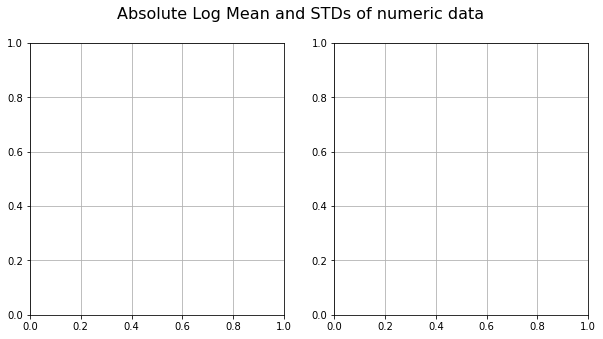

In [79]:
try:
  table_evaluator.visual_evaluation()
except ValueError:
  pass

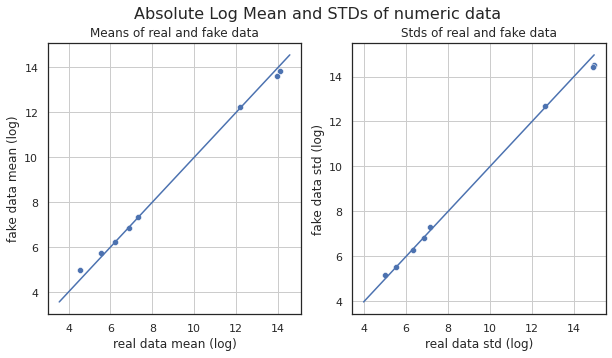

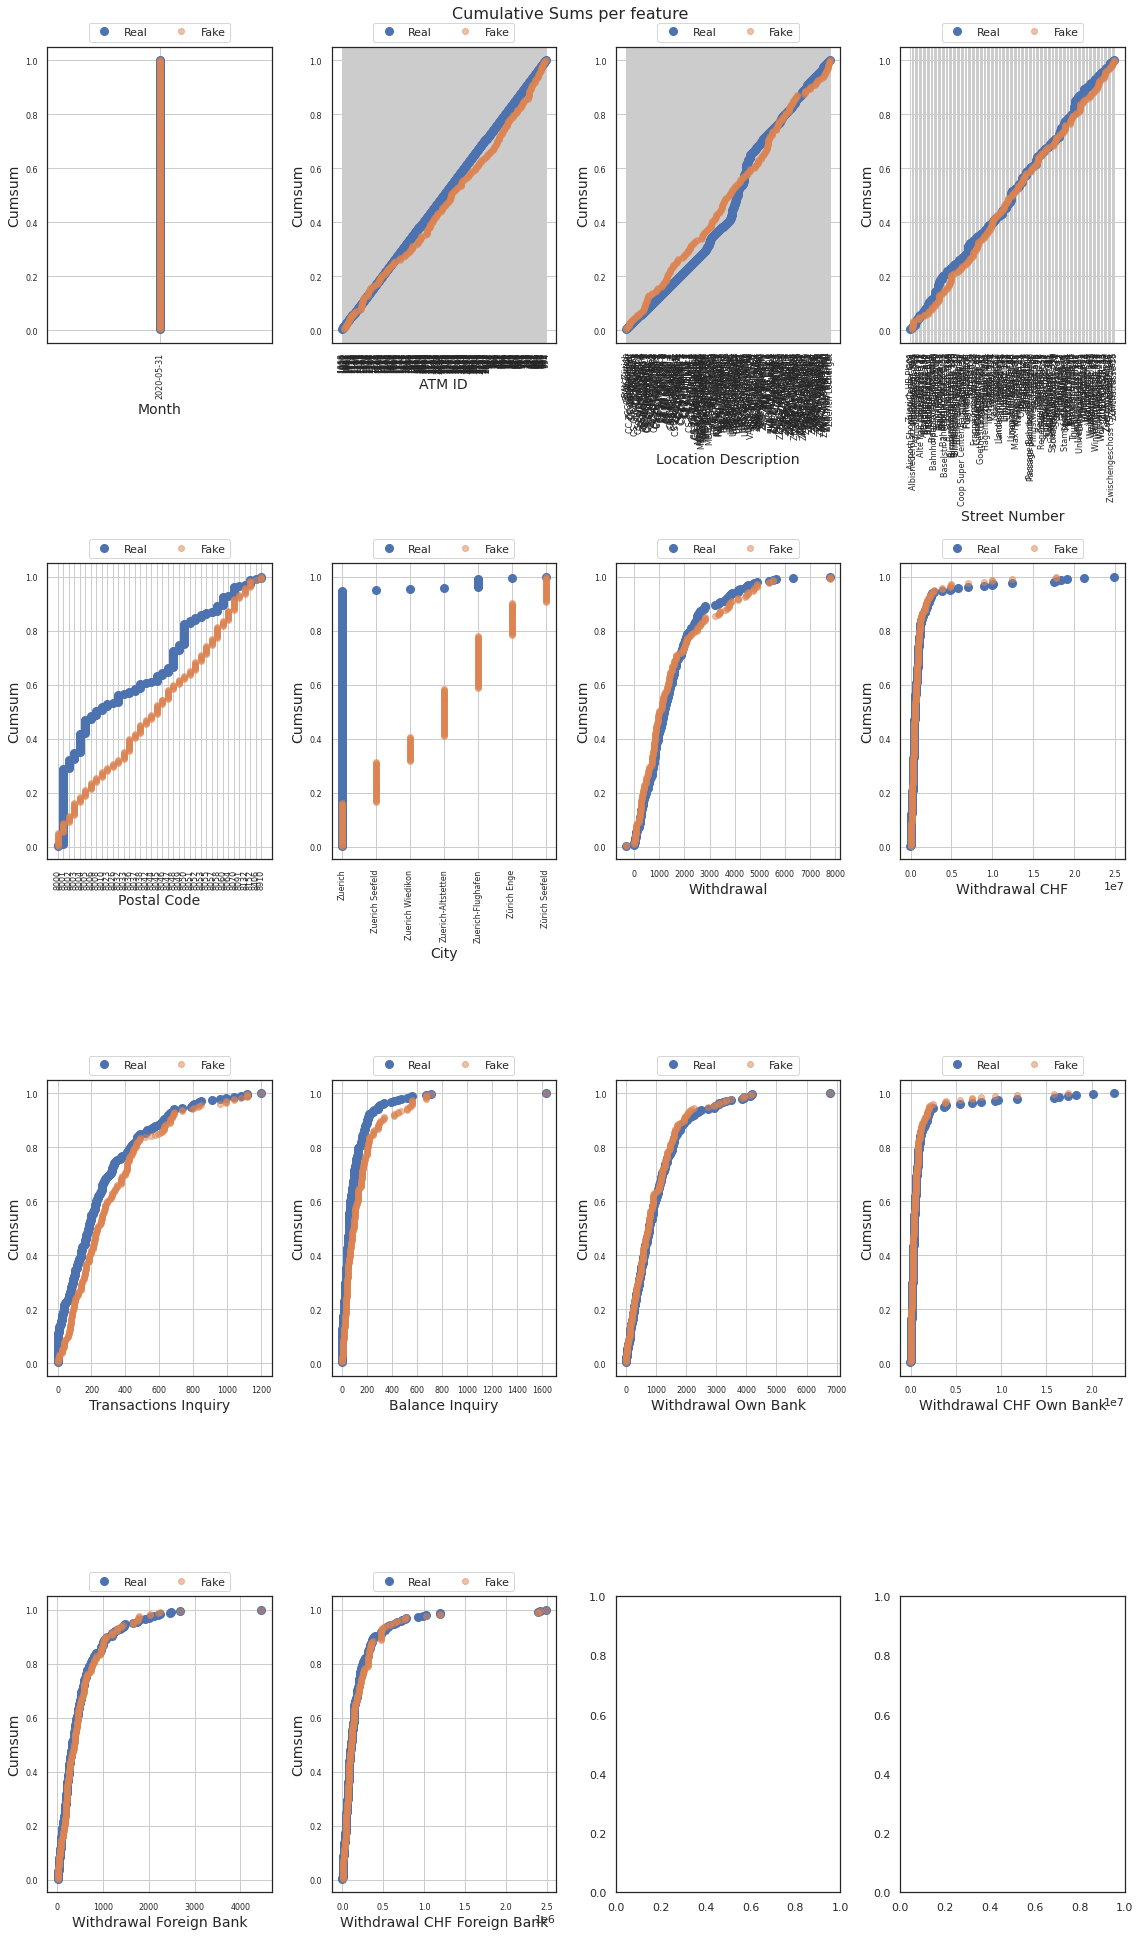

ValueError: ignored

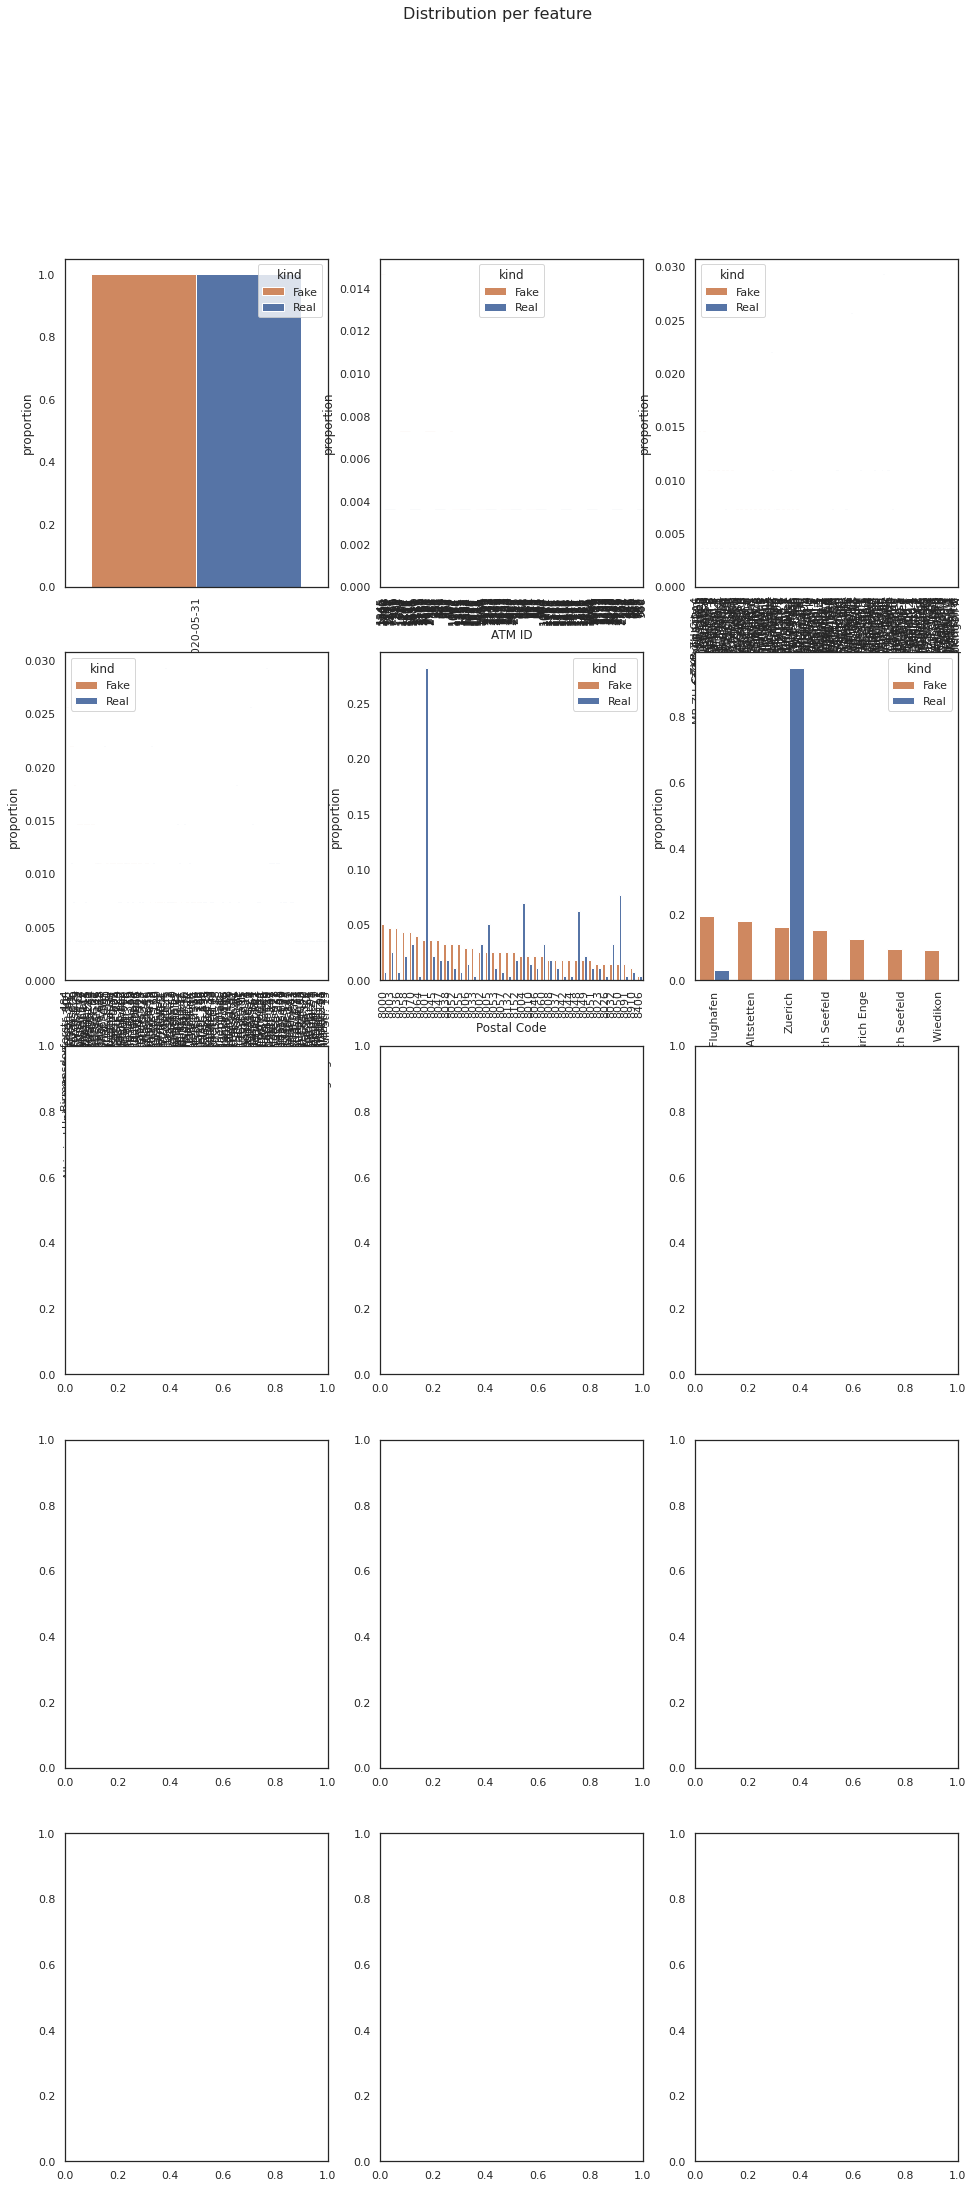

In [110]:
table_evaluator.visual_evaluation()